# Importing Libraries

In [1]:
!pip install albumentations

import os
import torch
import time
import cv2
import copy
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Genrating Augmentaion

In [2]:
# Training transformations for tomato disease detection using ResNeXt
train_transform = A.ReplayCompose([
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_REFLECT),
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
    A.ShiftScaleRotate(
        shift_limit=0.05, 
        scale_limit=0.1, 
        rotate_limit=20, 
        border_mode=cv2.BORDER_REFLECT, 
        p=0.5
    ),
    A.CenterCrop(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Validation transformations (no augmentation, just resize and normalize)
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [28]:
class AlbumentationsDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

In [29]:
data_dir_train = "/kaggle/input/tomato-disease-multiple-sources/"
data_dir_val = "/kaggle/input/tomato-disease-multiple-sources"

In [48]:
class SafeImageFolder(ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, loader=Image.open):
        super().__init__(root, transform=transform, target_transform=target_transform, loader=loader)

        # Filter out corrupted images once during init
        clean_samples = []
        for path, target in self.samples:
            try:
                img = Image.open(path)
                img.verify()  # Raises error if image is corrupted
                # Re-open and convert to RGB (3 channels)
                img = Image.open(path).convert('RGB')
                clean_samples.append((path, target))
            except Exception:
                print(f"Skipping corrupted image: {path}")
        self.samples = clean_samples
        self.imgs = self.samples  # for compatibility

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = Image.open(path).convert('RGB')  # Force RGB here too
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            target = self.target_transform(target)
        return img, target

In [49]:
train_folder = SafeImageFolder(os.path.join(data_dir_train, 'train'))
val_folder = SafeImageFolder(os.path.join(data_dir_val, 'valid'))

# Calculate the size of each subset (50% split)
val_size = len(val_folder)
test_size = val_size // 2
val_size = val_size - test_size  

# Split the validation dataset into validation and test subsets
val_subset, test_subset = random_split(val_folder, [val_size, test_size])

train_dataset = AlbumentationsDataset(train_folder, transform=train_transform)
train_woaug = AlbumentationsDataset(train_folder, transform=val_transform)
val_dataset = AlbumentationsDataset(val_subset, transform=val_transform)
test_dataset = AlbumentationsDataset(test_subset, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
trainaug_loader = DataLoader(train_woaug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Skipping corrupted image: /kaggle/input/tomato-disease-multiple-sources/valid/healthy/HL_(336).png


In [32]:
def find_corrupt_images(folder):
    corrupt_images = []
    for root, _, files in os.walk(folder):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                img = Image.open(path)
                img.verify()  # Verify without loading image data fully
            except Exception:
                corrupt_images.append(path)
    return corrupt_images

corrupted_train = find_corrupt_images(val_folder.root)
print("Corrupted images in Validation Folder:")
for c in corrupted_train:
    print(c)

Corrupted images in Validation Folder:
/kaggle/input/tomato-disease-multiple-sources/valid/healthy/HL_(336).png


In [33]:
 # os.remove(c)

# Showing Some Images

In [50]:
def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Function to print which augmentations were applied
def print_applied_transforms(replay):
    print("Applied augmentations:")
    for t in replay['transforms']:
        if t['applied']:
            print(f" - {t['__class_fullname__'].split('.')[-1]}")

def show_images_side_by_side(img1, img2, label, class_names, mean, std, replay=None):
    print("Displaying images:")
    print("- Left: Original (basic transform, no augmentation)")
    print("- Right: Augmented (train_transform with augmentation)")
    
    if replay:
        print("\n--- Applied Augmentations (from Replay) ---")
        for transform in replay['transforms']:
            if transform['applied']:
                print(f"✔ {transform['__class_fullname__']}")
            else:
                print(f"✘ {transform['__class_fullname__']} (not applied)")

    img1 = unnormalize(img1, mean, std).permute(1, 2, 0).cpu().numpy()
    img2 = unnormalize(img2, mean, std).permute(1, 2, 0).cpu().numpy()

    img1 = np.clip(img1, 0, 1)
    img2 = np.clip(img2, 0, 1)

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title(f"Original - {class_names[label]}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title(f"Augmented - {class_names[label]}")
    plt.axis('off')

    plt.show()

Image 1: Basic transform (Resize + Normalize + ToTensor)
Image 2: Train transform (with augmentation)
Displaying images:
- Left: Original (basic transform, no augmentation)
- Right: Augmented (train_transform with augmentation)

--- Applied Augmentations (from Replay) ---
✔ PadIfNeeded
✔ RandomResizedCrop
✔ HorizontalFlip
✘ VerticalFlip (not applied)
✘ RandomBrightnessContrast (not applied)
✘ HueSaturationValue (not applied)
✔ ShiftScaleRotate
✔ CenterCrop
✔ Normalize
✔ ToTensorV2


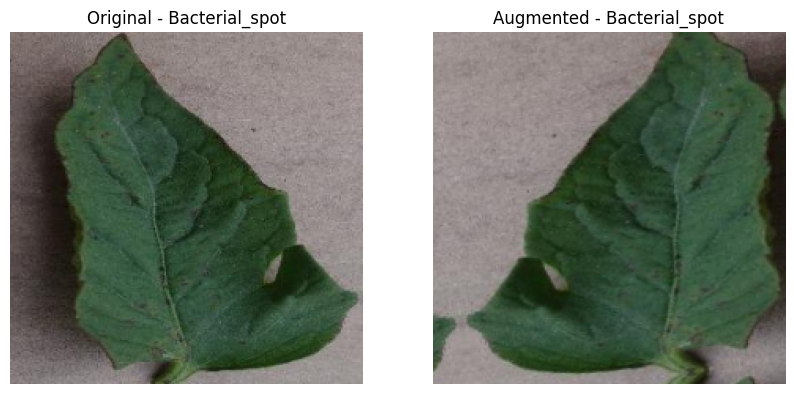

In [51]:
idx = 430

# Get image and label without augmentation
image_basic, label_basic = train_woaug[idx]

# Get image and label with augmentation
image_path, label_aug = train_folder.imgs[idx]

pil_img = Image.open(image_path).convert("RGB")
image_np = np.array(pil_img)

augmented = train_transform(image=image_np)
image_aug = augmented['image']
replay = augmented['replay']

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

print("Image 1: Basic transform (Resize + Normalize + ToTensor)")
print("Image 2: Train transform (with augmentation)")

show_images_side_by_side(image_basic, image_aug, label_basic, train_folder.classes, mean, std, replay)

In [52]:
def unnormalize_image(tensor, mean, std):
    """
    Reverses normalization of a tensor image.
    Args:
        tensor (Tensor): Normalized image tensor.
        mean (tuple): Mean used during normalization.
        std (tuple): Std dev used during normalization.
    Returns:
        Tensor: Unnormalized image tensor.
    """
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.tensor(std, dtype=tensor.dtype, device=tensor.device)
    return tensor * std[:, None, None] + mean[:, None, None]

In [53]:
def show_augmented_images_with_labels(loader, class_names, num_images=12, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Displays a grid of augmented images with their class labels.
    Args:
        loader (DataLoader): DataLoader containing image-label pairs.
        class_names (list): List of class names.
        num_images (int): Number of images to show.
        mean (tuple): Normalization mean.
        std (tuple): Normalization std.
    """
    images_shown = 0
    plt.figure(figsize=(12, 9))

    for images, labels in loader:
        for i in range(min(num_images, images.size(0))):
            img = images[i].clone()
            img = unnormalize_image(img, mean, std)
            img = np.clip(img.cpu().numpy().transpose(1, 2, 0), 0, 1)

            plt.subplot(4, 3, images_shown + 1)
            plt.imshow(img)
            plt.title(class_names[labels[i]])
            plt.axis('off')

            images_shown += 1
            if images_shown >= num_images:
                break
        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()

Training Set Augmentations:


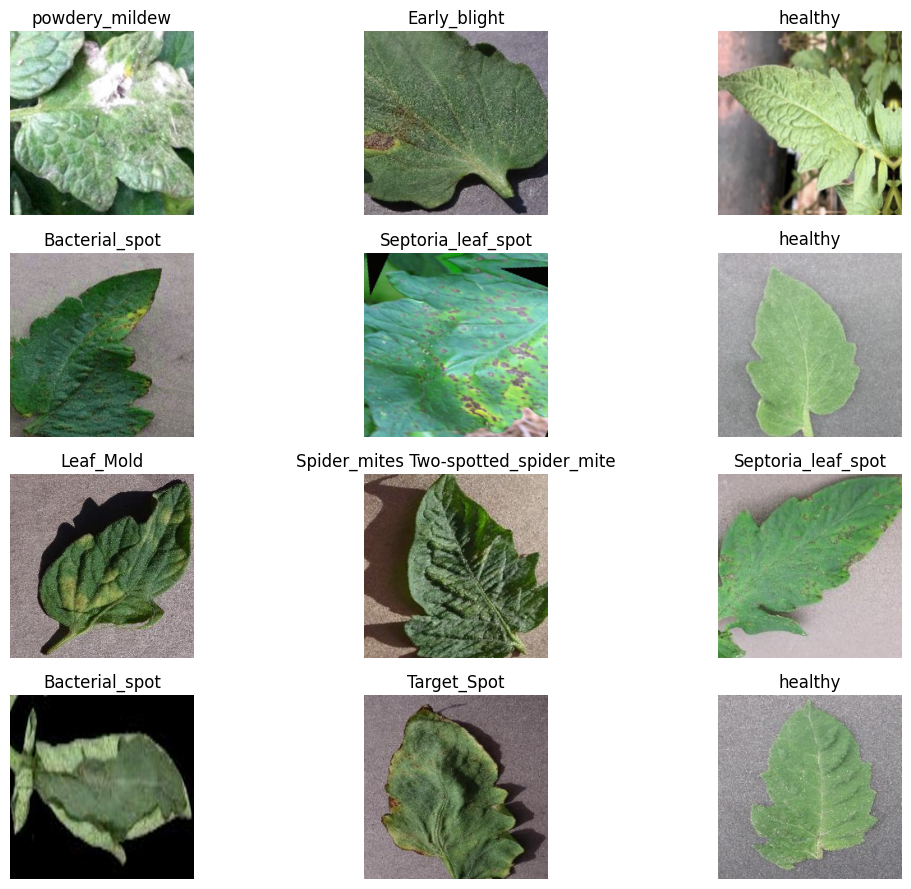

Test Set:


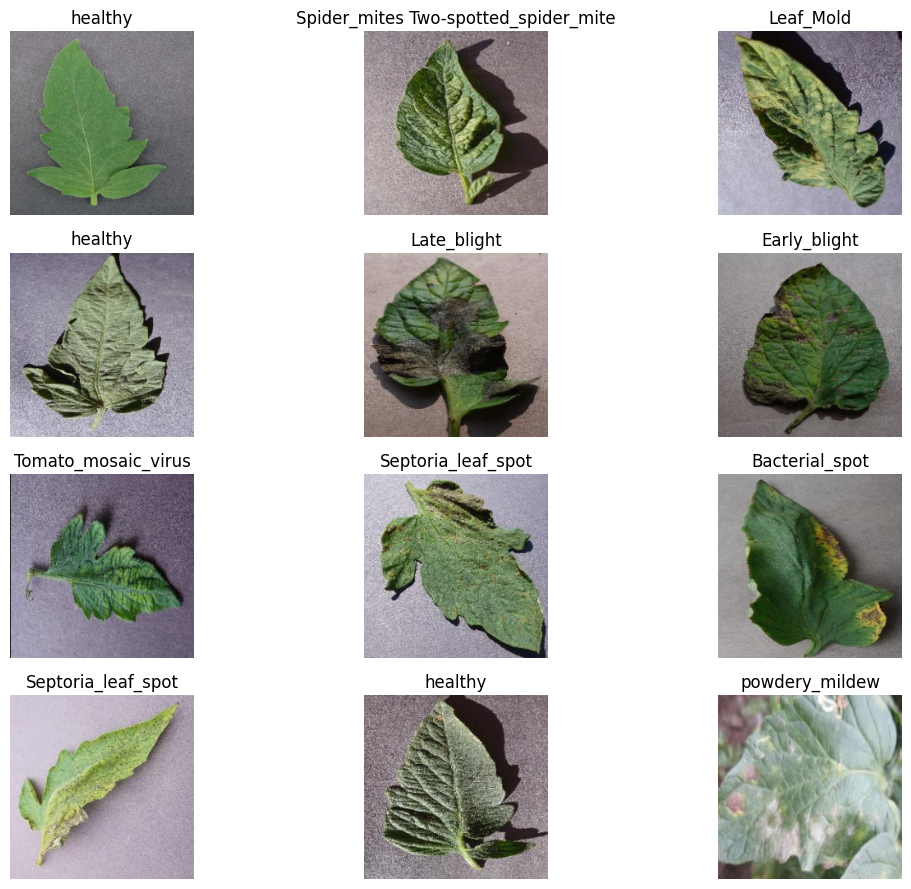

In [54]:
# Display augmented images from the training set
print("Training Set Augmentations:")
show_augmented_images_with_labels(train_loader, class_names=train_folder.classes)

# Display augmented images from the test set
print("Test Set:")
show_augmented_images_with_labels(test_loader, class_names=train_folder.classes)

# ResNetXt 50 Model

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNeXt-50 model
model = models.resnext50_32x4d(pretrained=True)

# Replace the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, len(train_folder.classes))

# Move the model to the device (GPU or CPU)
model = model.to(device)

In [56]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define Metric and Model Utilities

In [57]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct, preds

def save_best_model(model, val_acc, train_acc, best_val_acc, smallest_gap, 
                           min_train_acc=0.7, path='/kaggle/working/best_model.pth'):
    """
    Save model if:
    - Validation accuracy improves; OR
    - Validation accuracy ties best but the gap between train and val accuracy decreases; OR
    - Validation accuracy drops less than 1% but training accuracy is high and gap is small.
    """

    acc_gap = abs(train_acc - val_acc)

    improved = False
    # Case 1: validation accuracy improves significantly
    if val_acc > best_val_acc:
        improved = True
    # Case 2: validation accuracy ties but generalization gap improves
    elif val_acc == best_val_acc and acc_gap < smallest_gap:
        improved = True
    # Case 3: validation accuracy slightly worse but train acc high and gap small (within 1% tolerance)
    elif val_acc >= best_val_acc * 0.99 and train_acc >= min_train_acc and acc_gap < smallest_gap * 1.1:
        improved = True

    if improved:
        #torch.save(model.state_dict(), path)
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, path)
        print(f"Best model updated: val_acc={val_acc:.4f}, train_acc={train_acc:.4f}, gap={acc_gap:.4f}")
        return val_acc, acc_gap, True

    return best_val_acc, smallest_gap, False

# Defining Training Function for One Epoch

In [58]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        c, _ = calculate_accuracy(outputs, labels)
        correct += c
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    loss = running_loss / len(dataloader)
    accuracy = correct / total
    return loss, accuracy

# Defining Validation Function

In [59]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            c, _ = calculate_accuracy(outputs, labels)
            correct += c
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

    loss = val_loss / len(dataloader)
    accuracy = correct / total
    return loss, accuracy

# Run Training Loop

In [60]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    smallest_gap = float('inf')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Save best model
        best_val_acc, smallest_gap, updated = save_best_model(
            model, val_acc, train_acc, best_val_acc, smallest_gap
        )
        if updated:
            best_model_wts = copy.deepcopy(model.state_dict())

        # Logging
        time_elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {time_elapsed:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    # Load best model
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [61]:
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs = 5
)

Training:   0%|          | 0/808 [00:00<?, ?it/s]

Validating:   0%|          | 0/105 [00:00<?, ?it/s]

Best model updated: val_acc=0.9572, train_acc=0.8883, gap=0.0689
Epoch 1/5 - Time: 510.35s
  Train Loss: 0.3381 | Acc: 0.8883
  Val   Loss: 0.1491 | Acc: 0.9572


Training:   0%|          | 0/808 [00:00<?, ?it/s]

Validating:   0%|          | 0/105 [00:00<?, ?it/s]

Best model updated: val_acc=0.9755, train_acc=0.9523, gap=0.0232
Epoch 2/5 - Time: 515.87s
  Train Loss: 0.1474 | Acc: 0.9523
  Val   Loss: 0.0747 | Acc: 0.9755


Training:   0%|          | 0/808 [00:00<?, ?it/s]

Validating:   0%|          | 0/105 [00:00<?, ?it/s]

Best model updated: val_acc=0.9829, train_acc=0.9627, gap=0.0202
Epoch 3/5 - Time: 518.26s
  Train Loss: 0.1115 | Acc: 0.9627
  Val   Loss: 0.0554 | Acc: 0.9829


Training:   0%|          | 0/808 [00:00<?, ?it/s]

Validating:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/5 - Time: 525.76s
  Train Loss: 0.0944 | Acc: 0.9703
  Val   Loss: 0.0937 | Acc: 0.9728


Training:   0%|          | 0/808 [00:00<?, ?it/s]

Validating:   0%|          | 0/105 [00:00<?, ?it/s]

Best model updated: val_acc=0.9820, train_acc=0.9749, gap=0.0072
Epoch 5/5 - Time: 529.28s
  Train Loss: 0.0774 | Acc: 0.9749
  Val   Loss: 0.0628 | Acc: 0.9820


# Re-Training

In [ ]:
checkpoint = torch.load('/kaggle/input/your-checkpoint-folder/model_checkpoint.pth', map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
loss = checkpoint['loss']

In [78]:
# Resume training from next epoch
start_epoch = last_epoch + 1

NameError: name 'last_epoch' is not defined

# Plotting Model Loss and Accuracy

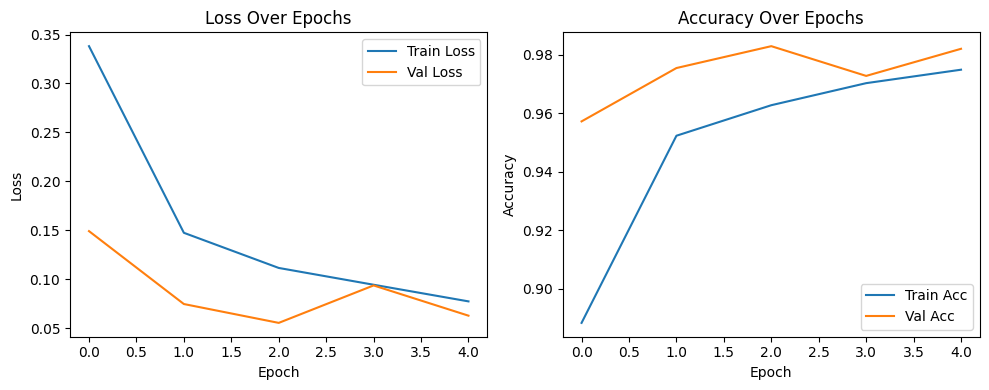

In [62]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate Model and Gather Predictions

In [63]:
def evaluate_model_on_test(model, test_loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(inputs.cpu())

    return np.array(all_images), np.array(all_labels), np.array(all_preds)

# Plot Confusion Matrix + Print Metrics

In [64]:
def plot_confusion_and_metrics(y_true, y_pred, class_names):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print(" Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

# Show Test Images with Prediction Results

In [75]:
import random

def show_predictions(images, labels, preds, class_names, mean, std, num_images=12):
    plt.figure(figsize=(15, 10))

    # Convert mean and std to np arrays for broadcasting
    mean = np.array(mean).reshape(1, 1, 3)
    std = np.array(std).reshape(1, 1, 3)

    indices = random.sample(range(len(images)), min(num_images, len(images)))

    for i, idx in enumerate(indices):
        img = images[idx]  # already numpy array
        if img.shape[0] == 3:  # (C, H, W)
            img = np.transpose(img, (1, 2, 0))  # -> (H, W, C)

        # Denormalize
        img = img * std + mean
        img = np.clip(img, 0, 1)

        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        correct = labels[idx] == preds[idx]
        color = 'green' if correct else 'red'

        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

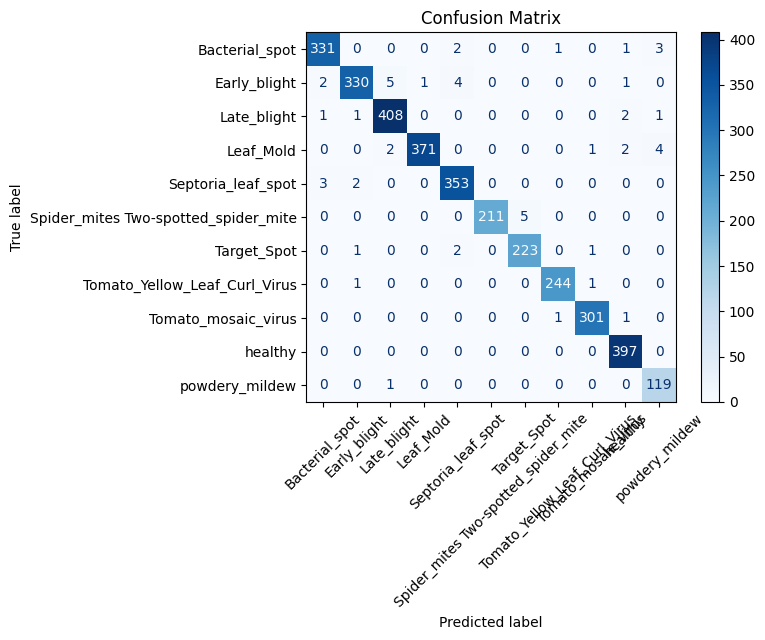

 Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot     0.9822    0.9793    0.9807       338
                        Early_blight     0.9851    0.9621    0.9735       343
                         Late_blight     0.9808    0.9879    0.9843       413
                           Leaf_Mold     0.9973    0.9763    0.9867       380
                  Septoria_leaf_spot     0.9778    0.9860    0.9819       358
Spider_mites Two-spotted_spider_mite     1.0000    0.9769    0.9883       216
                         Target_Spot     0.9781    0.9824    0.9802       227
       Tomato_Yellow_Leaf_Curl_Virus     0.9919    0.9919    0.9919       246
                 Tomato_mosaic_virus     0.9901    0.9934    0.9918       303
                             healthy     0.9827    1.0000    0.9913       397
                      powdery_mildew     0.9370    0.9917    0.9636       120

                            accuracy  

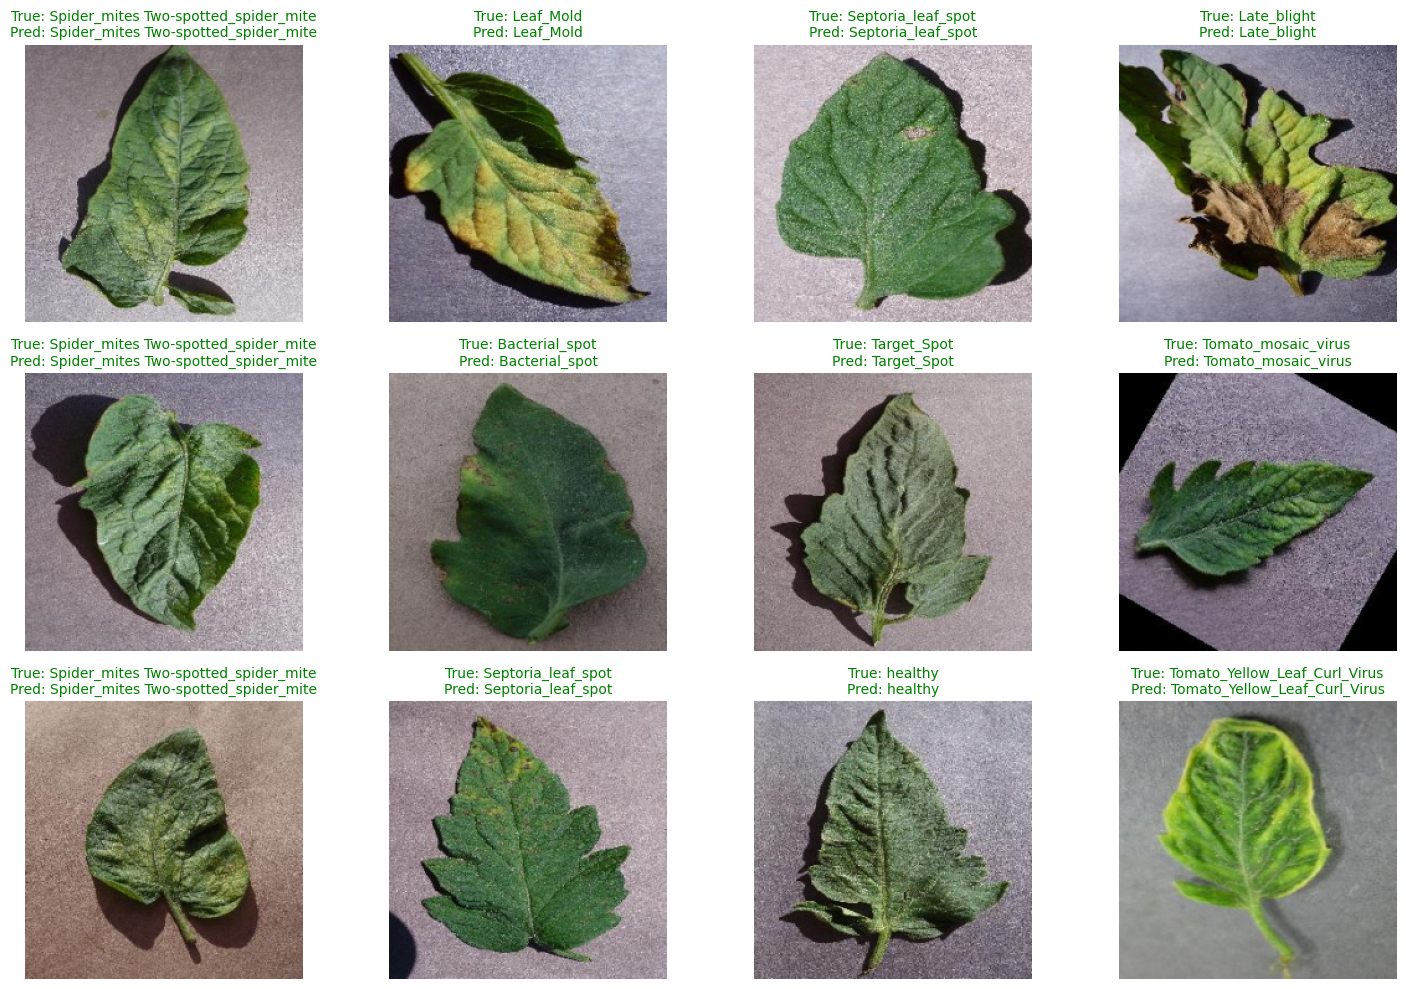

In [76]:
# Run evaluation
test_images, test_labels, test_preds = evaluate_model_on_test(model, test_loader, train_folder.classes, device)

# Show confusion matrix & metrics
plot_confusion_and_metrics(test_labels, test_preds, train_folder.classes)

# Show 12 predictions
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

show_predictions(test_images, test_labels, test_preds, class_names=train_folder.classes, mean=mean, std=std)